In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

Chargement des données

In [ ]:
data = load_breast_cancer()
X = data.data.astype(float)
y01 = data.target.astype(int)
y = np.where(y01 == 1, 1.0, -1.0)

In [ ]:
n, d = X.shape
print("n =", n, "d =", d)

n = 569 d = 30


### Standardisation

In [ ]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0) + 1e-12
X = (X - X_mean) / X_std

# 3) Fonctions F(w) et gradF(w)

In [ ]:
def F(w, X, y, lam):
    """
    F(w) = (1/n) sum log(1 + exp(-y_i x_i^T w)) + (lam/2)||w||^2
    """
    z = y * (X @ w)  # (n,)
    loss = np.logaddexp(0.0, -z).mean()  # stable numerically
    reg = 0.5 * lam * np.dot(w, w)
    return loss + reg
def grad_F(w, X, y, lam):
    """
    grad F(w) = -(1/n) sum [ y_i x_i / (1 + exp(y_i x_i^T w)) ] + lam w
    """
    z = y * (X @ w)          # (n,)
    a = 1.0 / (1.0 + np.exp(z))  # sigmoid(-z)
    grad = -(X.T @ (y * a)) / X.shape[0] + lam * w
    return grad

### les paramètres

In [ ]:
lam = 1e-2

In [ ]:
smax = np.linalg.svd(X, compute_uv=False)[0]
L = lam + (smax**2) / (4.0 * n)
alpha = 1.0 / L

### La Descente de Gradient à pas fixe

In [ ]:
w = np.zeros(d)
max_iter = 3000
tol = 1e-10

In [ ]:
hist_F = []
hist_grad = []
hist_time = []
t0 = time.time()

In [ ]:
for k in range(max_iter):
    g = grad_F(w, X, y, lam)
    w_new = w - alpha * g

    hist_F.append(F(w, X, y, lam))
    hist_grad.append(np.linalg.norm(g))
    hist_time.append(time.time() - t0)

    if np.linalg.norm(w_new - w) < tol:
        w = w_new
        break

    w = w_new

### Courbes de convergence

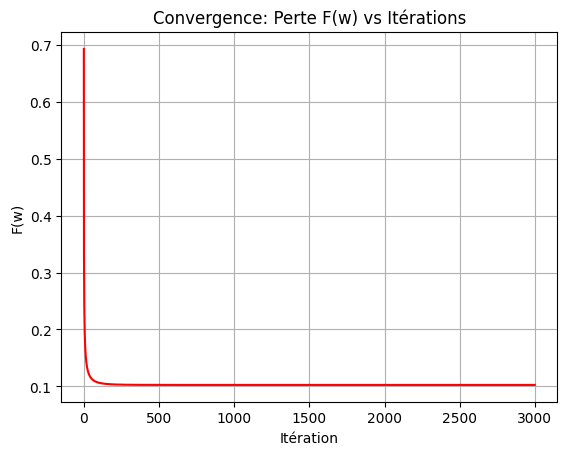

In [ ]:
plt.figure()
plt.plot(hist_F, color='red')
plt.xlabel("Itération")
plt.ylabel("F(w)")
plt.title("Convergence: Perte F(w) vs Itérations")
plt.grid(True)
plt.savefig("loss_iterations.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
from scipy.optimize import minimize
def F_flat(w):
    return F(w, X, y, lam)

def grad_flat(w):
    return grad_F(w, X, y, lam)

w0 = np.zeros(d)

# Gradient Conjugué
res_cg = minimize(
    F_flat,
    w0,
    jac=grad_flat,
    method="CG",
    options={"gtol":1e-8, "maxiter":3000}
)

print("Gradient Conjugué")
print("Itérations :", res_cg.nit)
print("F(w*) :", res_cg.fun)
print("Temps :", res_cg.execution_time if hasattr(res_cg, "execution_time") else "OK")


Gradient Conjugué
Itérations : 34
F(w*) : 0.1024165657566901
Temps : OK


### Gradient Stochastique (SGD)


In [ ]:
def F(w, X, y, lam):
    z = y * (X @ w)
    loss = np.logaddexp(0.0, -z).mean()
    reg = 0.5 * lam * np.dot(w, w)
    return loss + reg

### Paramètres SGD

In [ ]:
lam = 1e-2
alpha0 = 0.5          # pas initial
epochs = 30
max_steps = epochs * n

In [ ]:
w_sgd = np.zeros(d)

In [ ]:
rng = np.random.default_rng(42)
eval_idx = rng.choice(n, size=min(200, n), replace=False)
Xe, ye = X[eval_idx], y[eval_idx]
hist_F_sgd = []
hist_time_sgd = []
t0 = time.time()

In [ ]:
for k in range(max_steps):
    i = rng.integers(0, n)
    xi = X[i]
    yi = y[i]

    # pas décroissant
    alpha_k = alpha0 / np.sqrt(1.0 + k)

    # gradient stochastique
    z = yi * (xi @ w_sgd)
    a = 1.0 / (1.0 + np.exp(z))
    g = -(yi * xi) * a + lam * w_sgd

    # mise à jour
    w_sgd -= alpha_k * g

    # suivi toutes les 200 itérations
    if k % 200 == 0:
        hist_F_sgd.append(F(w_sgd, Xe, ye, lam))
        hist_time_sgd.append(time.time() - t0)


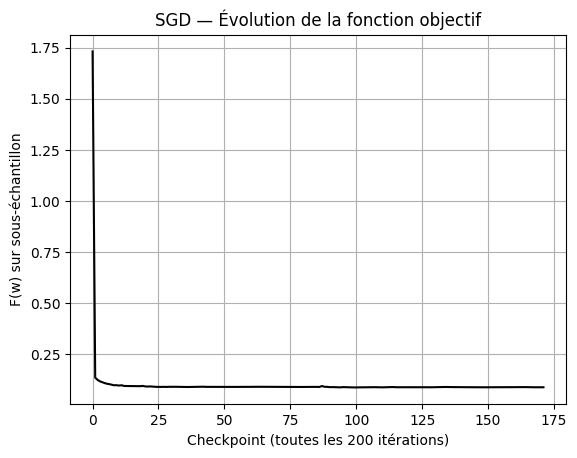

In [ ]:
plt.figure()
plt.plot(hist_F_sgd, color='black')
plt.xlabel("Checkpoint (toutes les 200 itérations)")
plt.ylabel("F(w) sur sous-échantillon")
plt.title("SGD — Évolution de la fonction objectif")
plt.grid(True)
plt.savefig("sgd_loss.png", dpi=300, bbox_inches="tight")
plt.show()

### l'alogorithme RMSProp vs Adam

In [ ]:
def F(w, X, y, lam):
    z = y * (X @ w)
    loss = np.logaddexp(0.0, -z).mean()
    reg = 0.5 * lam * np.dot(w, w)
    return loss + reg
def grad_i(w, xi, yi, lam):
    z = yi * (xi @ w)
    a = 1.0 / (1.0 + np.exp(z))
    g = -(yi * xi) * a + lam * w
    return g
def accuracy(w, X, y):
    pred = np.sign(X @ w)
    pred[pred == 0] = 1
    return (pred == y).mean()

In [ ]:
lam = 1e-2
epochs_early = 5
steps = epochs_early * n
eval_every = 200

rng = np.random.default_rng(123)
eval_idx = rng.choice(n, size=min(300, n), replace=False)
Xe, ye = X[eval_idx], y[eval_idx]

### l'algorithme RMSProp

In [ ]:
def run_rmsprop(alpha=0.001, rho=0.9, eps=1e-8):
    w = np.zeros(d)
    v = np.zeros(d)

    hist_loss, hist_time, hist_acc = [], [], []
    t0 = time.time()

    for k in range(1, steps + 1):
        i = rng.integers(0, n)
        xi, yi = X[i], y[i]
        g = grad_i(w, xi, yi, lam)

        v = rho * v + (1 - rho) * (g * g)
        w = w - alpha * g / (np.sqrt(v) + eps)

        if k % eval_every == 0 or k == 1:
            hist_loss.append(F(w, Xe, ye, lam))
            hist_acc.append(accuracy(w, Xe, ye))
            hist_time.append(time.time() - t0)

    return w, np.array(hist_loss), np.array(hist_time), np.array(hist_acc)

### l'algorithme Adam

In [ ]:
def run_adam(alpha=0.001, b1=0.9, b2=0.999, eps=1e-8):
    w = np.zeros(d)
    m = np.zeros(d)
    v = np.zeros(d)

    hist_loss, hist_time, hist_acc = [], [], []
    t0 = time.time()

    for k in range(1, steps + 1):
        i = rng.integers(0, n)
        xi, yi = X[i], y[i]
        g = grad_i(w, xi, yi, lam)

        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * (g * g)

        m_hat = m / (1 - b1**k)
        v_hat = v / (1 - b2**k)

        w = w - alpha * m_hat / (np.sqrt(v_hat) + eps)

        if k % eval_every == 0 or k == 1:
            hist_loss.append(F(w, Xe, ye, lam))
            hist_acc.append(accuracy(w, Xe, ye))
            hist_time.append(time.time() - t0)

    return w, np.array(hist_loss), np.array(hist_time), np.array(hist_acc)

In [ ]:
w_rms, loss_rms, time_rms, acc_rms = run_rmsprop(alpha=1e-3)
w_adam, loss_adam, time_adam, acc_adam = run_adam(alpha=1e-3)


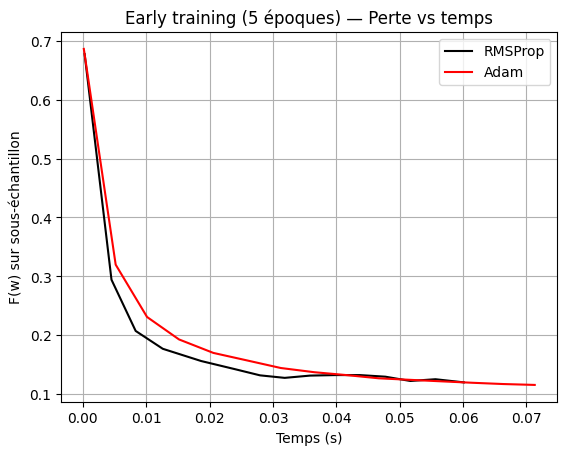

In [ ]:
# 2) Loss vs time
plt.figure()
plt.plot(time_rms, loss_rms, label="RMSProp", color='black')
plt.plot(time_adam, loss_adam, label="Adam", color='red')
plt.xlabel("Temps (s)")
plt.ylabel("F(w) sur sous-échantillon")
plt.title(f"Early training ({epochs_early} époques) — Perte vs temps")
plt.grid(True)
plt.legend()
plt.savefig("rmsprop_vs_adam_time.png", dpi=300, bbox_inches="tight")
plt.show()


### ISTA

In [ ]:
# Gradient de la perte logistique (sans L2)
def grad_f(w, X, y):
    z = y * (X @ w)
    a = 1.0 / (1.0 + np.exp(z))
    return -(X.T @ (y * a)) / X.shape[0]

# Fonction objectif Phi(w) = f(w) + lambda ||w||_1
def Phi(w, X, y, lam):
    z = y * (X @ w)
    loss = np.logaddexp(0.0, -z).mean()
    reg = lam * np.sum(np.abs(w))
    return loss + reg

  # Opérateur de seuil doux
def soft_threshold(v, thresh):
    return np.sign(v) * np.maximum(np.abs(v) - thresh, 0.0)

lam = 0.01
max_iter = 2000
tol = 1e-6

In [ ]:
# Constante de Lipschitz
smax = np.linalg.svd(X, compute_uv=False)[0]
L = (smax**2) / (4.0 * n)
alpha = 1.0 / L

# Initialisation
w_ista = np.zeros(d)

hist_Phi = []
t0 = time.time()

### ISTA

In [ ]:
for k in range(max_iter):
    grad = grad_f(w_ista, X, y)
    v = w_ista - alpha * grad
    w_new = soft_threshold(v, alpha * lam)

    hist_Phi.append(Phi(w_new, X, y, lam))

    if np.linalg.norm(w_new - w_ista) < tol:
        print(f"Convergence atteinte à l’itération {k}")
        break

    w_ista = w_new

print("ISTA terminé")
print("Valeur finale de Phi(w) =", hist_Phi[-1])
print("Nombre de coefficients non nuls =", np.sum(w_ista != 0))
print("Temps (s) =", time.time() - t0)

ISTA terminé
Valeur finale de Phi(w) = 0.16496745420672415
Nombre de coefficients non nuls = 13
Temps (s) = 160.4755139350891


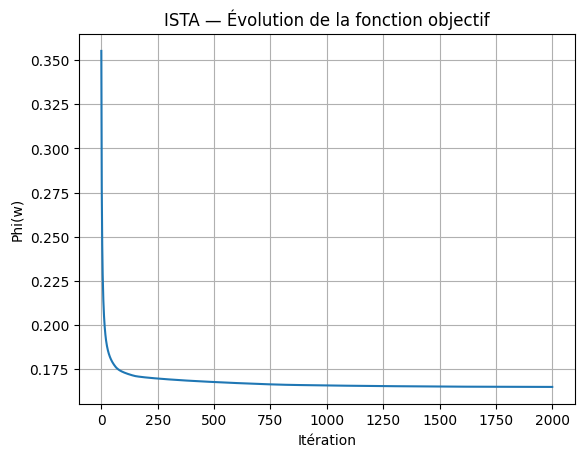

In [ ]:
plt.figure()
plt.plot(hist_Phi)
plt.xlabel("Itération")
plt.ylabel("Phi(w)")
plt.title("ISTA — Évolution de la fonction objectif")
plt.grid(True)
plt.show()

# FISTA

In [ ]:
# --- f : perte logistique (sans L2) ---
def f_loss(w, X, y):
    z = y * (X @ w)
    return np.logaddexp(0.0, -z).mean()

# --- gradient de f ---
def grad_f(w, X, y):
    z = y * (X @ w)
    a = 1.0 / (1.0 + np.exp(z))              # 1/(1+exp(yi xi^T w))
    return -(X.T @ (y * a)) / X.shape[0]

# --- Phi(w) = f(w) + lambda ||w||_1 ---
def Phi(w, X, y, lam):
    return f_loss(w, X, y) + lam * np.sum(np.abs(w))

# --- soft-thresholding prox_{tau||.||1} ---
def soft_threshold(v, tau):
    return np.sign(v) * np.maximum(np.abs(v) - tau, 0.0)

In [ ]:
# --- Lipschitz constant for grad f: L = ||X||_2^2 /(4n) ---
n = X.shape[0]
smax = np.linalg.svd(X, compute_uv=False)[0]
L = (smax**2) / (4.0 * n)
alpha = 1.0 / L
print("L =", L, "alpha=1/L =", alpha)

lam = 0.01
max_iter = 2000
tol = 1e-6

w_fista = np.zeros(X.shape[1])
w_prev  = w_fista.copy()
y_k     = w_fista.copy()
t_k     = 1.0

hist_Phi_fista = []
t0 = time.time()

L = 3.320401920417291 alpha=1/L = 0.30116835972505557


In [ ]:
for k in range(max_iter):
    # proximal gradient step at y_k
    v = y_k - alpha * grad_f(y_k, X, y)
    w_new = soft_threshold(v, alpha * lam)

    # update t and extrapolation
    t_new = 0.5 * (1.0 + np.sqrt(1.0 + 4.0 * t_k**2))
    y_new = w_new + ((t_k - 1.0) / t_new) * (w_new - w_prev)

    hist_Phi_fista.append(Phi(w_new, X, y, lam))

    # stopping criterion
    if np.linalg.norm(w_new - w_fista) < tol:
        print(f"FISTA: convergence à l'itération {k}")
        w_fista = w_new
        break

    w_prev = w_new
    w_fista = w_new
    y_k = y_new
    t_k = t_new

print("FISTA terminé")
print("Phi_final =", hist_Phi_fista[-1])
print("Nb coeffs non nuls =", np.sum(w_fista != 0))
print("Temps (s) =", time.time() - t0)

FISTA terminé
Phi_final = 0.16424637690213584
Nb coeffs non nuls = 11
Temps (s) = 2.625049591064453


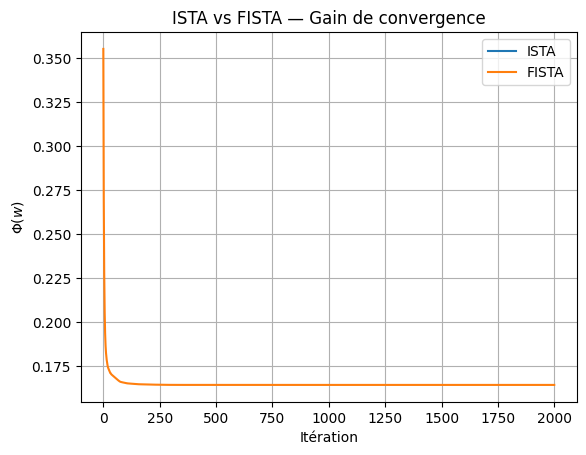

In [ ]:
plt.figure()
plt.plot(hist_Phi, label="ISTA")
plt.plot(hist_Phi_fista, label="FISTA")
plt.xlabel("Itération")
plt.ylabel(r"$\Phi(w)$")
plt.title("ISTA vs FISTA — Gain de convergence")
plt.grid(True)
plt.legend()
plt.savefig("ista_vs_fista.png", dpi=300, bbox_inches="tight")
plt.show()